In [ ]:
import kwant
import numpy as np
import kwant.continuum
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])


gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))   
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))  
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1
width=30


structure=kwant.lattice.square(las,norbs=4)
def make_syst(m,width=50,length=100):
    
    onsite =  m/2*gamma_1 - (4*B)/las**2 * gamma_2
    hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
    hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

    def model():
        
        model_sym= kwant.TranslationalSymmetry(structure.vec((1,0)),structure.vec((0,-1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0, 0)] = onsite
        model_1[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
        model_1[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

        return model_1

    ########### create the scattering center

    def shape_center(site):
        x, y = site.pos
        return 0 < x <= length and 0 < y <= width

    syst= kwant.Builder()
    syst.fill(model(), shape_center,(1,1))

    ########### create the leads

    width_lead = length//5 

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(model(), shape_lead0, (0, 1))
    lead1.fill(model(), shape_lead1, (width_lead+1, 0))
    lead2.fill(model(), shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()  


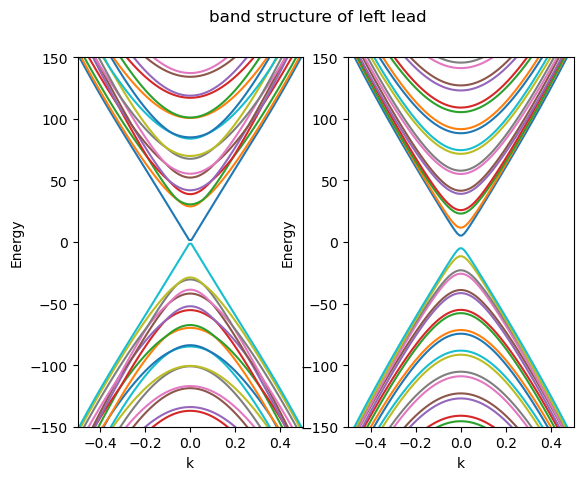

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

for ax in (ax1,ax2):
    ax.set_xlabel('k')
    ax.set_ylabel('Energy')
    ax.set_ylim(-150,150)
    ax.set_xlim(-0.5,0.5)

syst1=make_syst(50,60,300).leads[0] #提取系统的第一个引线
syst2=make_syst(10,60,300).leads[0]

kwant.plotter.bands(syst1,momenta=np.linspace(-0.5, 0.5, 100), ax=ax1);
kwant.plotter.bands(syst2,momenta=np.linspace(-0.5, 0.5, 100), ax=ax2);



In [5]:
syst3=make_syst(50,60,300)
smat = kwant.smatrix(syst3, energy=9.0)
tmat = smat.conductance_matrix()
np.round(tmat,3)

array([[ 1.   , -0.   , -0.   , -0.   , -0.   , -1.   ],
       [-1.   ,  1.   , -0.   , -0.   , -0.   , -0.   ],
       [-0.   , -0.999,  1.   , -0.   , -0.001, -0.   ],
       [-0.   , -0.   , -1.   ,  1.   , -0.   , -0.   ],
       [-0.   , -0.   , -0.   , -1.   ,  1.   , -0.   ],
       [-0.   , -0.001, -0.   , -0.   , -0.999,  1.   ]])

In [2]:
def find_voltages(tmatrix,current):  #注意：该函数返回的V是所有V的矩阵        #tmatrix是传输矩阵，在此处还未定义，current是电流分布[1, 0, 0, -1, 0, 0] 表示电流从端口1流入，端口4流出。
    try:                                                            #np.linalg.solve()函数用于求解线性方程组，返回值是一个数组，数组中的每个元素是一个未知数的解   
        voltage = np.linalg.solve(tmatrix[1:, 1:], current[1:])     #tmatrix[1:, 1:]表示tmatrix的第一行和第一列被删去 current[1:]表示current的第一个元素被删去  
    except np.linalg.LinAlgError as err:                            #当检测到奇异矩阵时，即该函数无解，避免程序崩溃，强制返回零电压
        if 'Singular matrix' in str(err):
            print("Hi there, singular matrix here")
            voltage = [0,0,0,0,0]
        else:
            raise
    return [0, *voltage]    ##在电压列表前添加一个 0，表示第一个端口的电压为0（参考接地）。
  
def resistance_xx(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(a, b): 
        return voltage[a-1]-voltage[b-1] ##默认电流为1 ###将端口的序号索引转化为数组索引
  
    return resistance(2, 5) ##电流从端口2流入，端口3流出，电压差为V2-V3
  
def resistance_xy(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(a, b):
        return voltage[a-1]-voltage[b-1]
  
    return resistance(6, 3)  

Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here


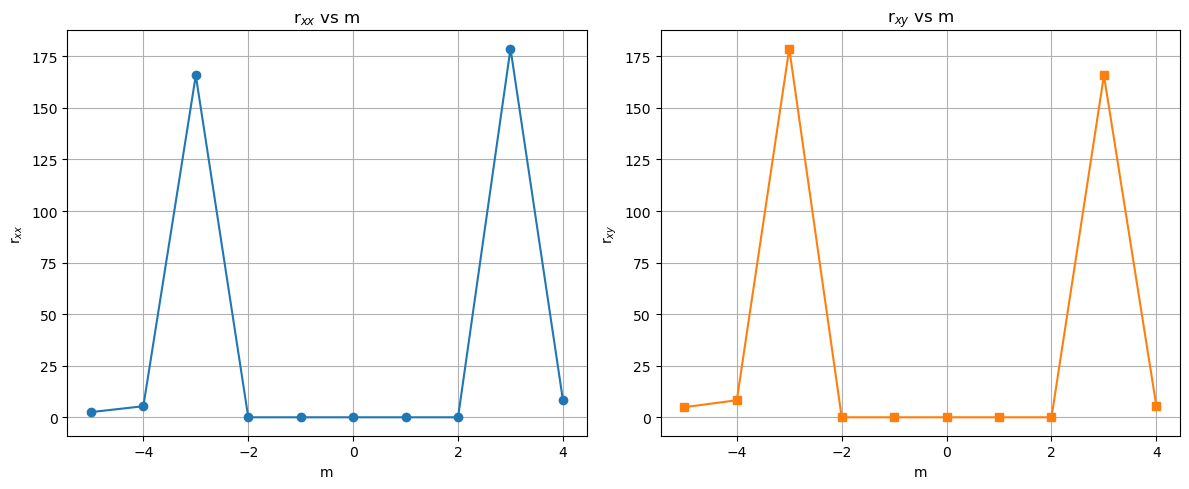

: 

In [ ]:
# 计算不同m值下的电阻
m_values = np.arange(-5, 5,1)  
rxx_list = []
rxy_list = []

for m in m_values:
    syst = make_syst(m, width=60, length=300)
    smat = kwant.smatrix(syst, energy=7.0)
    tmat = smat.conductance_matrix()
    rxx_list.append(resistance_xx(tmat))
    rxy_list.append(resistance_xy(tmat))

#画图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(m_values, rxx_list, 'o-', color='C0')
ax1.set_xlabel('m')
ax1.set_ylabel('r$_{xx}$')
ax1.set_title('r$_{xx}$ vs m')
ax1.grid(True)

ax2.plot(m_values, rxy_list, 's-', color='C1')
ax2.set_xlabel('m')
ax2.set_ylabel('r$_{xy}$')
ax2.set_title('r$_{xy}$ vs m')
ax2.grid(True)

plt.tight_layout()
plt.show()